## LLM을 활용한 데이터 증강 test
- 목적: 기존과 거의 동일하면서도 일부 표현에 차이가 있어, 최종적으로 동일한 label을 갖도록 하는 데이터셋 증강
- 방법
    - sentence_1, sentence_2, label 입력으로 주면 이에 적절하게 sentence_1 및 sentence_2를 재작성해 n개의 문장 쌍 생성, 반환. 해당 라벨 값은 기존과 동일하게 부여함.
    - few-shot 통해 0점부터 5점까지 점수대별로 예시 제공.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

plt.rcParams['font.family'] = 'AppleGothic'  # plt에서 한글 깨짐 현상 방지 (local 환경)
plt.rcParams['axes.unicode_minus'] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data_train = pd.read_csv("../../data/train_preprocess_v1.csv")

### 데이터 얼마나 생성해야 할까?

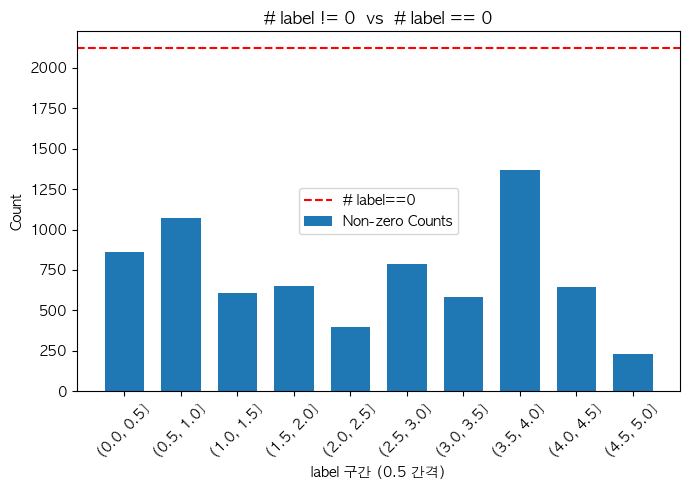

In [2]:
# 0이 아닌 값들의 히스토그램 생성
bin_edges = np.arange(0, 5.5, 0.5)  # 구간 정의
non_zero_counts = pd.cut(data_train[data_train['label'] > 0]['label'], bins=bin_edges).value_counts().sort_index()
zero_count = (data_train['label'] == 0).sum()

# 그래프 그리기
plt.figure(figsize=(7, 5))
plt.bar(non_zero_counts.index.astype(str), non_zero_counts.values, width=0.7, label='Non-zero Counts')
plt.axhline(zero_count, color='r', linestyle='--', label='# label==0')
plt.title('# label != 0  vs  # label == 0')
plt.xlabel('label 구간 (0.5 간격)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# 각 구간별 필요한 배수 계산
multipliers = zero_count / non_zero_counts
multipliers_round = round(multipliers)
print(multipliers_round)

label
(0.0, 0.5]    2.0
(0.5, 1.0]    2.0
(1.0, 1.5]    3.0
(1.5, 2.0]    3.0
(2.0, 2.5]    5.0
(2.5, 3.0]    3.0
(3.0, 3.5]    4.0
(3.5, 4.0]    2.0
(4.0, 4.5]    3.0
(4.5, 5.0]    9.0
Name: count, dtype: float64


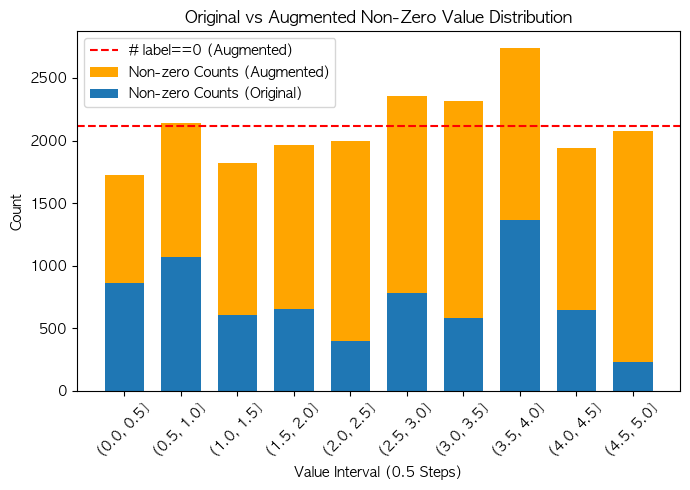

In [4]:
# 데이터가 해당 배수만큼 증강된다면,
augmented_counts = non_zero_counts.copy()
for bin_range in augmented_counts.index:
    multiplier = multipliers_round[bin_range]
    augmented_counts[bin_range] = int(round(multiplier) * non_zero_counts[bin_range])

# 그래프 그리기
plt.figure(figsize=(7, 5))
plt.bar(augmented_counts.index.astype(str), augmented_counts.values, width=0.7, color='orange', label='Non-zero Counts (Augmented)')
plt.bar(non_zero_counts.index.astype(str), non_zero_counts.values, width=0.7, label='Non-zero Counts (Original)')
plt.axhline(zero_count, color='r', linestyle='--', label='# label==0 (Augmented)')
plt.title('Original vs Augmented Non-Zero Value Distribution')
plt.xlabel('Value Interval (0.5 Steps)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# 위와 같은 그래프 뽑기 위해 각 구간별로 추가 생성해야 하는 문장 쌍 개수
nums_to_generate = multipliers_round - 1
nums_to_generate

label
(0.0, 0.5]    1.0
(0.5, 1.0]    1.0
(1.0, 1.5]    2.0
(1.5, 2.0]    2.0
(2.0, 2.5]    4.0
(2.5, 3.0]    2.0
(3.0, 3.5]    3.0
(3.5, 4.0]    1.0
(4.0, 4.5]    2.0
(4.5, 5.0]    8.0
Name: count, dtype: float64

## LLM 불러와 데이터 증강해보자
- `gpt-4o-mini` 모델

In [6]:
from openai import OpenAI

client = OpenAI(api_key="(본인 키 입력)")

In [7]:
system_prompt = '''당신은 문장 쌍을 재작성하는 전문가입니다. 주어진 두 문장의 의미적 관계를 유지하면서 표현을 변형하는 것이 당신의 임무입니다.

[지시사항]
1. 입력된 두 문장의 의미적 관계를 분석하세요.
2. 주어진 점수를 참고하여 두 문장 간의 의미 차이 정도를 파악하세요.
3. 각 문장을 재작성할 때:
   - 원래 문장의 핵심 의미를 유지하세요.
   - 가능한 한 다양한 동의어와 대체 표현을 사용하세요.
   - 문장 구조를 변경하되, 원래의 뉘앙스를 보존하세요.
4. 재작성된 문장 쌍은 원래 문장 쌍과 동일한 의미적 관계(점수)를 유지해야 합니다.
5. 요청된 수만큼 문장 쌍을 생성하세요.

[점수 기준]
0.0: 완전히 다른 내용
1.0: 유사한 주제, 다른 핵심 내용
2.0: 일부 공통점, 다른 핵심 내용
3.0: 유사한 핵심 내용, 부가 내용에 상당한 차이
4.0: 동일한 핵심 내용, 부가 내용에 미미한 차이
5.0: 완전히 동일한 내용

[주의사항]
- 원래 문장의 길이와 복잡성을 유지하세요.
- 문화적 맥락과 어조를 고려하세요.
- 재작성된 문장이 자연스럽고 유창해야 합니다.
- 특정 도메인의 전문 용어를 사용할 경우, 일관성을 유지하세요.

[출력 형식]
1. (재작성된 문장1), (재작성된 문장2)
2. (재작성된 문장1), (재작성된 문장2)
...
'''


user_prompt = '''원본 문장1: {sentence_1}
원본 문장2: {sentence_2}
점수: {score}
생성할 문장 쌍 수: {num_to_generate}
'''

In [8]:
few_shot = {
    'ex0': {
        'sentence_1': '오오 ㅎㅎㅎ 딱 꽂아 두셨네요^^',
        'sentence_2': '오오오 대박! 기대됩니다!!',
        'score': 0.0,
        'num_to_generate': 1,
        'answer': '''1. (와우, 정말 멋지게 배치하셨네요!), (대박이에요! 정말 기대가 됩니다.)'''
    },
    'ex1': {
        'sentence_1': "앞으로 답변은 '청와대가 이렇게 하겠습니다'로 해주세요.",
        'sentence_2': "청와대의 직접 소통은 '국민이 물으면 정부가 답한다'라는 철학을 지향합니다.",
        'score': 1.0,
        'num_to_generate': 2,
        'answer': '''1. (앞으로는 '청와대의 공식 입장'으로 응답해 주시기 바랍니다.), (청와대는 '국민의 질문에 정부가 답변한다'는 원칙으로 직접 소통을 추구합니다.)
2. (향후 답변은 '청와대의 공식 견해'로 표현해 주십시오.), (청와대의 직접적인 의사소통은 '시민의 의견을 듣고 정부가 응답한다'는 이념을 추구합니다.)'''
    },
    'ex2': {
        'sentence_1': '환경미화원 안전보장',
        'sentence_2': '환경미화원 근무 개선 및 급여 인상',
        'score': 2.2,
        'num_to_generate': 4,
        'answer': '''1. (청소 노동자의 안전 보장 강화), (환경미화원의 근로 조건 개선 및 임금 상향 조정)
2. (환경미화원의 안전 확보 방안 마련), (환경미화 종사자의 업무 환경 향상과 보수 인상)
3. (미화원의 안전 대책 수립), (청소 근로자의 직무 여건 개선 및 급여 상향)
4. (환경 미화원의 안전성 제고 정책), (청소 작업자의 근무 여건 향상 및 보수 증액)'''
    },
    'ex3': {
        'sentence_1': "이야기하면서 놀랐던 포인트는 'Upstage'의 비전과 가치를 빼놓을 수 없을 것 같아요!",
        'sentence_2': "이야기하면서 놀랐던 점은 '업 스테이지'의 비전과 가치였다.",
        'score': 3.4,
        'num_to_generate': 3,
        'answer': '''1. (대화 중 가장 인상 깊었던 점은 'Upstage'가 지향하는 비전과 가치관이었습니다!), (대화를 나누면서 가장 놀라웠던 것은 '업 스테이지'의 미래 방향성과 핵심 가치였습니다.)
2. (토론 과정에서 특히 눈에 띄었던 것은 'Upstage'의 장기적 목표와 기업 철학이었어요.), (대화를 통해 가장 흥미로웠던 부분은 '업 스테이지'의 미래 비전과 추구하는 가치였습니다.)
3. (대화 중 가장 주목할 만했던 요소는 'Upstage'의 미래 청사진과 핵심 가치관이었습니다.), (토론하면서 가장 인상적이었던 점은 '업 스테이지'의 장기 목표와 기업 이념이었습니다.)'''
    },
    'ex4': {
        'sentence_1': '자주 활용 안 하신다면 이모지에 클릭해 주세요!',
        'sentence_2': '자주 사용하지 않는다면 이모티콘을 클릭!',
        'score': 4.2,
        'num_to_generate': 1,
        'answer': '''1. (자주 사용하지 않으시면 이모티콘 아이콘을 눌러주세요!), (빈번히 활용하지 않는다면 이모지 버튼을 클릭해 주세요.)'''
    },
    'ex5': {
        'sentence_1': '검정고시 폐지해야 한다고 봅니다',
        'sentence_2': '검정고시가 폐지되어야 한다고 봅니다',
        'score': 5.0,
        'num_to_generate': 4,
        'answer': '''1. (검정고시는 폐지되어야 한다고 생각합니다.), (검정고시는 없애야 한다고 판단됩니다.)
2. (검정고시 제도는 폐지되어야 한다는 의견입니다.), (검정고시는 없어져야 한다는 생각입니다.)
3. (검정고시 시험은 폐지가 필요하다고 봅니다.), (검정고시는 없애야 한다고 생각합니다.)
4. (검정고시는 폐지되어야 한다고 믿습니다.), (검정고시 제도는 없어져야 한다고 확신합니다.)'''
    }
}


# Few-shot 예시를 프롬프트에 추가
few_shot_examples = "\n\n".join([
    f"예시 {i+1}:\n원본 문장1: {ex['sentence_1']}\n원본 문장2: {ex['sentence_2']}\n점수: {ex['score']}\n생성할 문장 쌍 수: {ex['num_to_generate']}\n\n답변:\n{ex['answer']}"
    for i, ex in enumerate(few_shot.values())
])

In [ ]:
# 동일한 맥락의 문장 쌍 생성하는 함수
def generate_sentences(sentence_1, sentence_2, score, num_to_generate):
    # 사용자 프롬프트 생성
    user_prompt_filled = user_prompt.format(
        sentence_1=sentence_1,
        sentence_2=sentence_2,
        score=score,
        num_to_generate=num_to_generate
    )
    # 전체 프롬프트 구성
    prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": few_shot_examples},
        {"role": "assistant", "content": "이해했습니다. 주어진 예시들을 참고하여 문장 쌍을 재작성하겠습니다."},
        {"role": "user", "content": user_prompt_filled}
    ]
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=prompt
        )
        result = response.choices[0].message.content
        return result
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

# 생성해야 하는 문장 쌍 개수 반환
def get_to_generate(label):
    for interval, count in nums_to_generate.items():
        if interval.left < label <= interval.right:
            return int(count)
    return None  # 해당하는 구간이 없을 경우

# 생성된 문자 파싱
def extract_sentences(input_string):
    pattern = r'\d+\.\s*\((.*?)\),\s*\((.*?)\)'  # 번호. (문장1), (문장2) 형식의 문장 추출
    matches = re.findall(pattern, input_string, re.DOTALL)
    return matches

In [31]:
sentence_1 = '아이유 연기 잘하던데 작가 땜에 망했네'
sentence_2 = '강동원 연기 진짜 잘하네요'
test1 = generate_sentences(sentence_1, sentence_2, 1.2, 3)
print(test1, '\n')

sentence_1 = '서민들이 너무 살기 힘듦'
sentence_2 = '물가 때문에 살기가 너무 힘듭니다'
test2 = generate_sentences(sentence_1, sentence_2, 2.8, 3)
print(test2, '\n')

sentence_1 = '대화 주제가 너무 다양해서 정말 재미있어요!! ㅎㅎ'
sentence_2 = '정말 다양한 대화 주제가 있어서 정말 재미있어요!! 헤헤'
test3 = generate_sentences(sentence_1, sentence_2, 1.2, 3)
print(test3)

1. (아이유는 연기를 잘하는 것 같은데 작가 때문에 실패한 거죠.), (강동원의 연기는 정말 뛰어난 거 같아요.)
2. (아이유는 연기가 괜찮았던 것 같은데 작가의 문제로 아쉬움을 남겼네요.), (강동원의 연기력은 진정으로 대단해요.)
3. (아이유가 연기를 잘했지만 작가로 인해 좋지 않은 결과가 나왔네요.), (강동원의 연기 실력은 정말 탁월합니다.) 

1. (서민들이 살아가기 매우 어려워요), (물가 상승 때문에 생존이 극히 힘겨워요.)
2. (일반 서민들이 경제적으로 많이 어렵습니다), (물가탓에 생계가 매우 힘들어지고 있습니다.)
3. (서민들의 생활이 매우 고통스럽습니다), (물가로 인해 생활이 힘든 상황입니다.) 

1. (대화의 주제가 너무나 다양해서 정말 즐거워요!! ㅎㅎ), (정말 다양한 화제로 대화를 나눌 수 있어서 참 즐겁습니다!! 헤헤)
2. (대화 주제가 여러 가지여서 정말 신나는 것 같아요!! ㅎㅎ), (다양한 주제로 이야기할 수 있어서 정말 재미있네요!! 헤헤)
3. (대화의 주제가 너무 풍부해서 정말 재미있어요!! ㅎㅎ), (정말 많은 대화 주제가 있어서 정말 재미있습니다!! 헤헤)


In [12]:
data_train_nonzero = data_train[data_train['label'] > 0.0].reset_index(drop=True)
data_augmented = pd.DataFrame(columns=['id','source','sentence_1','sentence_2', 'label', 'binary-label'])

for i, row in data_train_nonzero.iterrows():
    id = row['id'] + '-DA'
    source = row['source']
    sentence_1 = row['sentence_1']
    sentence_2 = row['sentence_2']
    label = row['label']
    binary_label = row['binary-label']
    to_generate = get_to_generate(label)
    
    generated_sentences = generate_sentences(sentence_1, sentence_2, label, to_generate)
    
    # 생성된 문장들을 처리
    extracted_sentences = extract_sentences(generated_sentences)
    for _, (sent1, sent2) in enumerate(extracted_sentences, 1):
        new_row = pd.DataFrame({
            'id': [id],
            'source': [source],
            'sentence_1': [sent1],
            'sentence_2': [sent2],
            'label': [label],  
            'binary-label': [binary_label] 
        })
        data_augmented = pd.concat([data_augmented, new_row], ignore_index=True)
    
    print(f"{i+1}/7205: accumulated {len(data_augmented)}")
    
    # 100개 데이터마다 CSV 파일로 저장
    # if i % 100 == 0:
        # data_augmented.to_csv('da_gpt4omini.csv', index=False)
        

# data_augmented.to_csv('da_gpt4omini.csv', index=False)

1/7205: accumulated 4
2/7205: accumulated 6
3/7205: accumulated 10
4/7205: accumulated 12
5/7205: accumulated 14
6/7205: accumulated 15
7/7205: accumulated 16
8/7205: accumulated 17
9/7205: accumulated 19
10/7205: accumulated 23
11/7205: accumulated 24
12/7205: accumulated 25
13/7205: accumulated 27
14/7205: accumulated 28
15/7205: accumulated 30
16/7205: accumulated 31
17/7205: accumulated 32
18/7205: accumulated 34
19/7205: accumulated 36
20/7205: accumulated 37
21/7205: accumulated 38
22/7205: accumulated 40
23/7205: accumulated 43
24/7205: accumulated 44
25/7205: accumulated 46
26/7205: accumulated 48
27/7205: accumulated 49
28/7205: accumulated 50
29/7205: accumulated 51
30/7205: accumulated 53
31/7205: accumulated 56
32/7205: accumulated 57
33/7205: accumulated 59
34/7205: accumulated 61
35/7205: accumulated 62
36/7205: accumulated 64
37/7205: accumulated 65
38/7205: accumulated 66
39/7205: accumulated 67
40/7205: accumulated 68
41/7205: accumulated 69
42/7205: accumulated 70
43/

In [14]:
# 기존 데이터와 증강한 데이터셋 합치기 (Preprocessing + Augmentation)
data_augmented_total = pd.concat([data_train, data_augmented], axis=0)

data_augmented.to_csv('../../data/train_only_da_gpt4omini.csv', index=False)
data_augmented_total.to_csv('../../data/train_preprocessing_da_gpt4omini.csv', index=False)

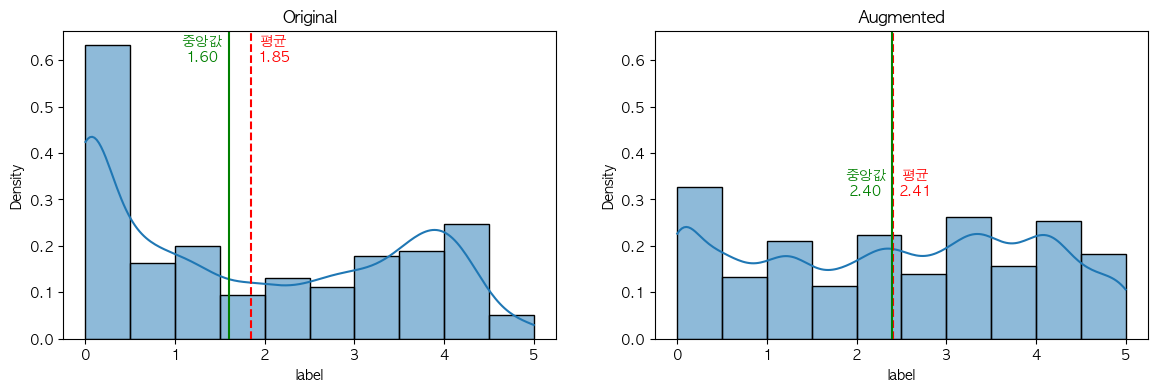

In [18]:
# label별 히스토그램 시각화
def label_histogram(data, title, ax):
    mean = data['label'].mean()
    median = data['label'].median()
    
    sns.histplot(data=data, x='label', stat='density', binwidth=0.5, kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Density')
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean + 0.25, ax.get_ylim()[1] * 0.9, f'평균\n{mean:.2f}', color='r', ha='center')
    ax.axvline(median, color='g', linestyle='-', label='Median')
    ax.text(median - 0.3, ax.get_ylim()[1] * 0.9, f'중앙값\n{median:.2f}', color='g', ha='center')


fig, axes = plt.subplots(1, 2, figsize=(14, 4))
label_histogram(data_train, 'Original', axes[0])
label_histogram(data_augmented_total, 'Augmented', axes[1])
max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)
plt.show()